In [1]:
import tensorflow as tf 
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import os
import matplotlib.pyplot as plt
import time 


In [2]:
class RBM():
    def __init__(self, nv=2500, nh=64*8, cd_steps=3):
        self.graph = tf.Graph() 
        with self.graph.as_default(): 
            self.W = tf.Variable(tf.truncated_normal((nv, nh)) * 0.01)
            self.bv = tf.Variable(tf.zeros((nv, 1))) 
            self.bh = tf.Variable(tf.zeros((nh, 1)))
            
            self.cd_steps = cd_steps 
            self.modelW = None
            
            self.nv = nv
            self.nh = nh
            self.lr = 0.1
    
    def bernoulli(self, p):
        return tf.nn.relu(tf.sign(p - tf.random_uniform(p.shape)))
    
    def energy(self, v):
        b_term = tf.matmul(v, self.bv)
        linear_tranform = tf.matmul(v, self.W) + tf.squeeze(self.bh)
        h_term = tf.reduce_sum(tf.log(tf.exp(linear_tranform) + 1), axis=1) 
        return tf.reduce_mean(-h_term -b_term)
    
    def sample_h(self, v):
        ph_given_v = tf.sigmoid(tf.matmul(v, self.W) + tf.squeeze(self.bh))
        return self.bernoulli(ph_given_v)
    
    def sample_v(self, h):
        pv_given_h = tf.sigmoid(tf.matmul(h, tf.transpose(self.W)) + tf.squeeze(self.bv))
        return self.bernoulli(pv_given_h)
    
    def gibbs_step(self, i, k, vk):
        hk = self.sample_h(vk)
        vk = self.sample_v(hk)
        return i+1, k, vk
    
    #-----------------------------------AMIT
    def get_probabilities(self,layer, weights, val, bias):
        if layer == 'hidden':
            with tf.name_scope("Hidden_Probabilities"):
                return tf.nn.sigmoid(tf.matmul(val, weights) + bias)
        elif layer == 'visible':
            with tf.name_scope("Visible_Probabilities"):
                return tf.nn.sigmoid(tf.matmul(val, tf.transpose(weights)) + bias)
    
    def sample(self,probabilities):
        return tf.floor(probabilities + tf.random_uniform(tf.shape(probabilities), 0, 1))
    
    def gibbs(self,steps, v, hb, vb, W):
        with tf.name_scope("Gibbs_sampling"):
            for i in range(steps):
                hidden_p = self.get_probabilities('hidden', W, v, hb)
                h = self.sample(hidden_p)

                visible_p = self.get_probabilities('visible', W, h, vb)
                v = visible_p
                #v = self.sample(visible_p)
            return visible_p
    #-----------------------------------AMIT
    

In [3]:
X=np.load('features.npy')#loading Data
Y=np.load('labels.npy')


data = X 
print(data)


[[0.4        0.4        0.36078431 ... 0.55686275 0.58039216 0.60392157]
 [0.59215686 0.4        0.66666667 ... 0.32156863 0.31372549 0.32156863]
 [0.63137255 0.60392157 0.71764706 ... 0.51372549 0.55686275 0.67843137]
 ...
 [0.34117647 0.32941176 0.35294118 ... 0.41176471 0.40784314 0.41960784]
 [0.51764706 0.54117647 0.57254902 ... 0.37254902 0.37647059 0.45098039]
 [0.16078431 0.14117647 0.11764706 ... 0.45098039 0.38431373 0.42352941]]


In [7]:
#SESSION------------>

sess = tf.InteractiveSession()

rbm_model= RBM(cd_steps=3)

# Placeholder for the visible layer of the RBM computation graph.
v    = tf.placeholder(tf.float32, shape=[None,rbm_model.nv], name="visible_layer")
size = tf.cast(tf.shape(v)[0], tf.float32)



# Initialize weights and biases a la Hinton
with tf.name_scope('Weights'):
    W = tf.Variable(tf.random_normal([rbm_model.nv, rbm_model.nh], mean=0., stddev=4 * np.sqrt(6. / (rbm_model.nv + rbm_model.nh))), name="weights")
    tf.summary.histogram('weights',W)

    

vb = tf.Variable(tf.zeros([1,rbm_model.nv]),tf.float32, name="visible_bias")
hb = tf.Variable(tf.zeros([1,rbm_model.nh]),tf.float32, name="hidden_bias")



# Similarity between reconstructed/sampled visible layer and input during training. 
# Summary for Tensorboard visualization 
with tf.name_scope("Reconstruction_error"): 
    reconstruction_error = tf.Variable(0.0,name="reconstruction_error")
    tf.summary.scalar('reconstruction_error',reconstruction_error)

#--------------------->

In [8]:
# K-step Contrastive Divergence using Gibbs sampling
# Positive divergence   


with tf.name_scope('Hidden_probabilities'):
    pos_hid_prob = rbm_model.get_probabilities('hidden',W,v,hb)
with tf.name_scope('Positive_Divergence'):
    pos_divergence = tf.matmul(tf.transpose(v),pos_hid_prob)

    

pos_hid_states = rbm_model.sample(pos_hid_prob)
neg_vis_prob = rbm_model.get_probabilities('visible', W, pos_hid_states, vb)
#neg_vis_states = rbm.sample(neg_vis_prob)


# Negative divergence
with tf.name_scope('Negative_hidden_probabilities'):
    neg_hid_prob = rbm_model.get_probabilities('hidden', W, neg_vis_prob, hb)
with tf.name_scope('Negative_Divergence'):
    neg_divergence = tf.matmul(tf.transpose(neg_vis_prob),neg_hid_prob)
    
    

# Accuracy on reconstructing visible layer and free energy
a = tf.reduce_mean(tf.squared_difference(v,neg_vis_prob))
rec_error = [reconstruction_error.assign(a)]
#energy  =  rbm.free_energy(v = v, weights=W,hbias=hb,vbias=vb) 
#accuracy_update = [accuracy.assign_add(reconstruction_accuracy)]



In [9]:
# Update rules for weights and biases
# Summaries of gradient for Tensorboard visualization


with tf.name_scope('Weight_gradient'):
    delta_w = tf.multiply(rbm_model.lr/size, tf.subtract(pos_divergence,neg_divergence))
    weight_gradient_scalar = tf.summary.scalar('weight_increment',tf.reduce_mean(delta_w))
    

with tf.name_scope('Visible_bias_gradient'):
    delta_vb = tf.multiply(rbm_model.lr/size, tf.reduce_sum(tf.subtract(v,neg_vis_prob), 0, keepdims=True))
    
    
with tf.name_scope('Hidden_bias_gradient'):
    delta_hb= tf.multiply(rbm_model.lr/size, tf.reduce_sum(tf.subtract(pos_hid_prob,neg_hid_prob), 0, keepdims=True))

    
update = [W.assign_add(delta_w), vb.assign_add(delta_vb), hb.assign_add(delta_hb)]


# Merge summaries for Tensorboard
summary = tf.summary.merge_all()
path_test = os.getcwd()  + '/RBM_logs/Teeth_Classification'
test_writer = tf.summary.FileWriter(path_test,sess.graph)

sess.run(tf.global_variables_initializer())


In [14]:
start_time = time.time()

#####------------------------- Start of training ----------------######

y_ = tf.placeholder(tf.float32, [None, 10])


epochs = 3000
for epoch in range(epochs):
    if epoch % 200 == 0:
        feed={v: data} 
        result = sess.run([rec_error,summary],feed_dict=feed)
        acc = result[0]
        test_writer.add_summary(result[1],epoch)
        print("Reconstruction error at step %s: %s" % (epoch, acc))
        
    else: 
        batchXs, batchYs = X,Y 
        feed={v: batchXs}#,y: batchYs}
        result = sess.run([update], feed_dict = feed)
        

##### --------------- ######       
#####------------------- End of Training ----------------------######

# Plot

print("Elapsed time for training Bernoulli RBM with CD-1 and %s epochs: %s "%(epochs,time.time()-start_time))
#rbm.plot_weight_update(x=np.arange(0,rbm_model.epochs,1),y=np.abs(err))


Reconstruction error at step 0: [0.037211098]
Reconstruction error at step 200: [0.036922093]
Reconstruction error at step 400: [0.03702763]
Reconstruction error at step 600: [0.0365574]
Reconstruction error at step 800: [0.036339227]
Reconstruction error at step 1000: [0.036268085]
Reconstruction error at step 1200: [0.03626464]
Reconstruction error at step 1400: [0.03632857]
Reconstruction error at step 1600: [0.03554157]
Reconstruction error at step 1800: [0.035152666]
Reconstruction error at step 2000: [0.035485588]
Reconstruction error at step 2200: [0.03501805]
Reconstruction error at step 2400: [0.034839105]
Reconstruction error at step 2600: [0.03477617]
Reconstruction error at step 2800: [0.03475149]
Elapsed time for training Bernoulli RBM with CD-1 and 3000 epochs: 537.274849653244 


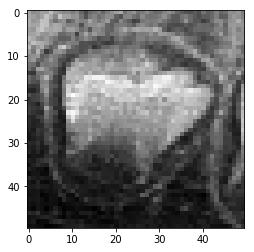

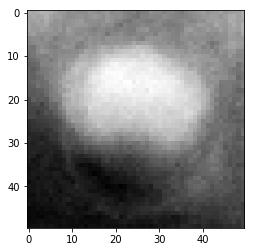

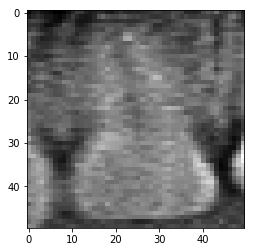

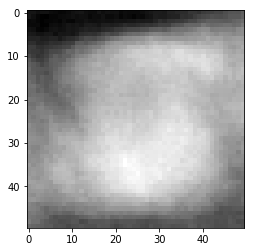

In [15]:
##### Testing ##### 
# Testing the RBM for one sample step after learning the weights    


first_image = 20

test_image  = X[20] 
test_image2 = X[50] 
def show_teeth(x):
    plt.imshow(x.reshape((50,50)),cmap = plt.cm.gray)
    plt.show()

sample = rbm_model.gibbs(1,v=v,hb=hb,vb=vb,W=W).eval(session=sess, feed_dict={v: test_image.reshape(1,-1).astype(np.float32)})    
sample_test = rbm_model.gibbs(1,v=v,hb=hb,vb=vb,W=W).eval(session=sess, feed_dict={v: test_image2.reshape(1,-1).astype(np.float32)})    
show_teeth(test_image)
show_teeth(sample)

show_teeth(test_image2)
show_teeth(sample_test)
tf.reset_default_graph()

